# Equity ETF intraday momentum

This notebook aims to replicate the result reported in Gao 2018 where the author investigated the intraday momentum in the SPY ETF. Unlike the traditional time-series momentum where lookbacks are sufficiently long (typically several months to 1 year), the paper looks at intraday price patterns (i.e., within a day). Concretely, the author reports that the first 30 minutes return from the previous day's close predicts the last 30 minutes on the same day.

In [1]:
from datetime import datetime
import logging
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import pytz
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('bmh')

from vivace.backtest import BacktestEngine, signal, InstrumentDef, processing
from vivace.backtest.analytics import PredictiveAnalysisTS, rebase
from vivace.backtest.stats import Performance
from vivace.enums import Strategy, PnLType

# Predictive analysis

There are 3 different intraday returns which are investigated in the paper:
- $r_{1}$: previous day's close to the first 30 mins
- $r_{12}$: close - 60 mins to close - 30 mins
- $r_{13}$: close - 30 mins to close

Let's first create the 30-min return series of SPY to replicate this analysis. Prices between 9:30 and 16:00 are used to avoid using prices in the after-hour sessions.

In [2]:
instrument = InstrumentDef('SPY', freq='30min', timezone='America/New_York',
                           start_time='9:30', end_time='16:00', pnl_type=PnLType.CLOSE.value)

In [3]:
spy_long_only = BacktestEngine(
    strategy=Strategy.DELTA_ONE.value,
    instrument=instrument,
    log_level=logging.WARN
)
spy_long_only.run()

In [4]:
spy_long_only_return = spy_long_only.get_return()

In [5]:
r1 = spy_long_only_return.loc[(spy_long_only_return.index.hour == 9) & 
                              (spy_long_only_return.index.minute == 30)].rename('r1')
r12 = spy_long_only_return.loc[(spy_long_only_return.index.hour == 15) & 
                               (spy_long_only_return.index.minute == 0)].rename('r12')
r13 = spy_long_only_return.loc[(spy_long_only_return.index.hour == 15) & 
                               (spy_long_only_return.index.minute == 30)].rename('r13')

# drop time info so they can be concatenated
r1.index = r1.index.date
r12.index = r12.index.date
r13.index = r13.index.date

# sometimes we don't have intraday returns because of half-day sessions
r1 = r1.reindex(index=r13.index)
r12 = r12.reindex(index=r13.index)

## $r_1$ only

As per the study, $r_1$ is statistically significant. The coefficient is positive which means the existence of intraday momentum.

Note that the predictive analysis of time-series signal is conducted by a class called `PredictiveAnalysisTS` which is a part of the private `vivace` library. This is just a shortcut to run various OLS models.

In [6]:
model = PredictiveAnalysisTS(r1, r13)

In [7]:
model.ols().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    r13   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     62.15
Date:                Mon, 29 Jul 2024   Prob (F-statistic):           4.00e-15
Time:                        09:03:45   Log-Likelihood:                 18073.
No. Observations:                4340   AIC:                        -3.614e+04
Df Residuals:                    4338   BIC:                        -3.613e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.778e-05   5.71e-05     -0.836      0.403      -0.000    6.42e-05
r1             0.0588      0.007      7.883      0.000       0.044       0.073
==============================================================================
Omnibus:                     1356.875   Durbin-Watson:                   2.278
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           122424.835
Skew:                           0.515   Prob(JB):                         0.00
Kurtosis:                      28.999   Cond. No.                         131.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let's reproduce the expanding OLS chart done in the paper. Unfortunately because of the data availability, data only starts from just before the global financial crisis when the coefficient happens to be particularly large. As the data sample grew, the coefficient somewhat stabilised over time and approached to the same level as the original paper (around a coefficient of 5 after the 100x scaling).

Interestingly, the $r_1$ coefficient spiked up again during the COVID sell-off in 2020.

In [8]:
beta, r = model.ols_expanding(min_periods=13 * 21)

Dynamic OLS:   0%|          | 0/4340 [00:00<?, ?it/s]

Dynamic OLS:   8%|▊         | 345/4340 [00:00<00:01, 3445.86it/s]

Dynamic OLS:  16%|█▌        | 690/4340 [00:00<00:02, 1341.43it/s]

Dynamic OLS:  20%|██        | 888/4340 [00:00<00:02, 1184.03it/s]

Dynamic OLS:  24%|██▍       | 1039/4340 [00:00<00:02, 1112.80it/s]

Dynamic OLS:  27%|██▋       | 1168/4340 [00:00<00:02, 1063.96it/s]

Dynamic OLS:  30%|██▉       | 1285/4340 [00:01<00:02, 1027.98it/s]

Dynamic OLS:  32%|███▏      | 1394/4340 [00:01<00:02, 998.54it/s] 

Dynamic OLS:  34%|███▍      | 1497/4340 [00:01<00:02, 975.42it/s]

Dynamic OLS:  37%|███▋      | 1597/4340 [00:01<00:02, 956.59it/s]

Dynamic OLS:  39%|███▉      | 1694/4340 [00:01<00:02, 940.13it/s]

Dynamic OLS:  41%|████      | 1789/4340 [00:01<00:02, 901.82it/s]

Dynamic OLS:  43%|████▎     | 1880/4340 [00:01<00:02, 884.14it/s]

Dynamic OLS:  45%|████▌     | 1969/4340 [00:01<00:02, 874.17it/s]

Dynamic OLS:  47%|████▋     | 2057/4340 [00:02<00:02, 820.27it/s]

Dynamic OLS:  49%|████▉     | 2140/4340 [00:02<00:02, 822.66it/s]

Dynamic OLS:  51%|█████     | 2223/4340 [00:02<00:02, 821.73it/s]

Dynamic OLS:  53%|█████▎    | 2306/4340 [00:02<00:02, 819.48it/s]

Dynamic OLS:  55%|█████▌    | 2389/4340 [00:02<00:02, 817.29it/s]

Dynamic OLS:  57%|█████▋    | 2472/4340 [00:02<00:02, 819.98it/s]

Dynamic OLS:  59%|█████▉    | 2555/4340 [00:02<00:02, 809.18it/s]

Dynamic OLS:  61%|██████    | 2636/4340 [00:02<00:02, 799.36it/s]

Dynamic OLS:  63%|██████▎   | 2716/4340 [00:02<00:02, 797.94it/s]

Dynamic OLS:  64%|██████▍   | 2799/4340 [00:02<00:01, 804.77it/s]

Dynamic OLS:  66%|██████▋   | 2880/4340 [00:03<00:01, 805.25it/s]

Dynamic OLS:  68%|██████▊   | 2961/4340 [00:03<00:01, 803.52it/s]

Dynamic OLS:  70%|███████   | 3042/4340 [00:03<00:01, 799.55it/s]

Dynamic OLS:  72%|███████▏  | 3122/4340 [00:03<00:01, 786.26it/s]

Dynamic OLS:  74%|███████▍  | 3201/4340 [00:03<00:01, 785.59it/s]

Dynamic OLS:  76%|███████▌  | 3280/4340 [00:03<00:01, 784.36it/s]

Dynamic OLS:  77%|███████▋  | 3359/4340 [00:03<00:01, 783.22it/s]

Dynamic OLS:  79%|███████▉  | 3438/4340 [00:03<00:01, 784.12it/s]

Dynamic OLS:  81%|████████  | 3519/4340 [00:03<00:01, 789.96it/s]

Dynamic OLS:  83%|████████▎ | 3600/4340 [00:03<00:00, 792.98it/s]

Dynamic OLS:  85%|████████▍ | 3680/4340 [00:04<00:00, 793.24it/s]

Dynamic OLS:  87%|████████▋ | 3760/4340 [00:04<00:00, 794.47it/s]

Dynamic OLS:  89%|████████▊ | 3841/4340 [00:04<00:00, 796.16it/s]

Dynamic OLS:  90%|█████████ | 3921/4340 [00:04<00:00, 777.13it/s]

Dynamic OLS:  92%|█████████▏| 3999/4340 [00:04<00:00, 750.10it/s]

Dynamic OLS:  94%|█████████▍| 4075/4340 [00:04<00:00, 752.94it/s]

Dynamic OLS:  96%|█████████▌| 4153/4340 [00:04<00:00, 760.44it/s]

Dynamic OLS:  97%|█████████▋| 4230/4340 [00:04<00:00, 754.84it/s]

Dynamic OLS:  99%|█████████▉| 4306/4340 [00:04<00:00, 745.82it/s]

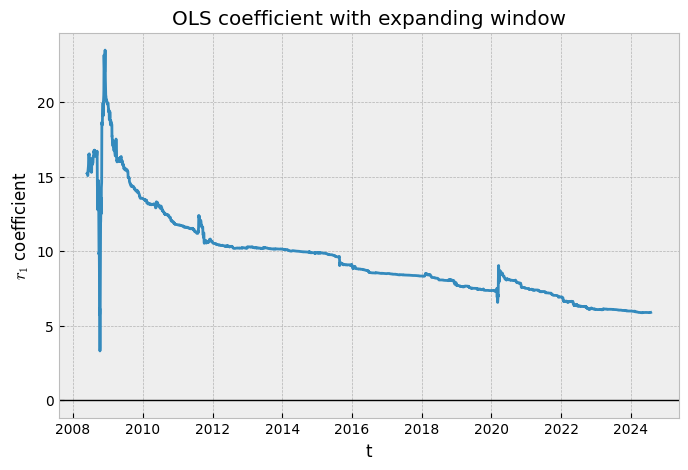

In [9]:
fig, ax = plt.subplots(figsize=(8, 5))
beta['r1'].mul(100).plot(ax=ax)
ax.set_ylabel('$r_1$ coefficient')
ax.set_title('OLS coefficient with expanding window')
ax.axhline(0, color='black', lw=1);

## $r_{12}$ only

Next is the same analysis but using only $r_{12}$.

In [10]:
model = PredictiveAnalysisTS(r12, r13)

In [11]:
model.ols().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    r13   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     77.55
Date:                Mon, 29 Jul 2024   Prob (F-statistic):           1.84e-18
Time:                        09:03:51   Log-Likelihood:                 18080.
No. Observations:                4340   AIC:                        -3.616e+04
Df Residuals:                    4338   BIC:                        -3.614e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.166e-05    5.7e-05     -0.731      0.465      -0.000    7.01e-05
r12            0.1730      0.020      8.806      0.000       0.134       0.211
==============================================================================
Omnibus:                     1211.665   Durbin-Watson:                   2.289
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           127282.979
Skew:                           0.155   Prob(JB):                         0.00
Kurtosis:                      29.529   Cond. No.                         345.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As noted by the author, the $r_{12}$ coefficient is also significant and is even larger than $r_1$ after the crisis. Over time this is approaching the same level as well (around 15 after the 100x scaling).

In [12]:
beta, r = model.ols_expanding(min_periods=13 * 21)

Dynamic OLS:   0%|          | 0/4340 [00:00<?, ?it/s]

Dynamic OLS:   8%|▊         | 350/4340 [00:00<00:01, 3472.72it/s]

Dynamic OLS:  16%|█▌        | 698/4340 [00:00<00:02, 1378.59it/s]

Dynamic OLS:  21%|██        | 898/4340 [00:00<00:02, 1198.64it/s]

Dynamic OLS:  24%|██▍       | 1050/4340 [00:00<00:02, 1119.30it/s]

Dynamic OLS:  27%|██▋       | 1180/4340 [00:00<00:02, 1067.79it/s]

Dynamic OLS:  30%|██▉       | 1297/4340 [00:01<00:02, 1026.50it/s]

Dynamic OLS:  32%|███▏      | 1405/4340 [00:01<00:02, 997.86it/s] 

Dynamic OLS:  35%|███▍      | 1508/4340 [00:01<00:02, 974.95it/s]

Dynamic OLS:  37%|███▋      | 1607/4340 [00:01<00:02, 956.83it/s]

Dynamic OLS:  39%|███▉      | 1704/4340 [00:01<00:02, 940.86it/s]

Dynamic OLS:  41%|████▏     | 1799/4340 [00:01<00:02, 924.81it/s]

Dynamic OLS:  44%|████▎     | 1892/4340 [00:01<00:02, 913.22it/s]

Dynamic OLS:  46%|████▌     | 1984/4340 [00:01<00:02, 905.70it/s]

Dynamic OLS:  48%|████▊     | 2075/4340 [00:01<00:02, 897.54it/s]

Dynamic OLS:  50%|████▉     | 2165/4340 [00:02<00:02, 889.53it/s]

Dynamic OLS:  52%|█████▏    | 2254/4340 [00:02<00:02, 883.83it/s]

Dynamic OLS:  54%|█████▍    | 2343/4340 [00:02<00:02, 879.06it/s]

Dynamic OLS:  56%|█████▌    | 2431/4340 [00:02<00:02, 872.17it/s]

Dynamic OLS:  58%|█████▊    | 2519/4340 [00:02<00:02, 874.19it/s]

Dynamic OLS:  60%|██████    | 2607/4340 [00:02<00:01, 872.72it/s]

Dynamic OLS:  62%|██████▏   | 2695/4340 [00:02<00:01, 871.39it/s]

Dynamic OLS:  64%|██████▍   | 2783/4340 [00:02<00:01, 867.58it/s]

Dynamic OLS:  66%|██████▌   | 2870/4340 [00:02<00:01, 865.05it/s]

Dynamic OLS:  68%|██████▊   | 2957/4340 [00:02<00:01, 858.86it/s]

Dynamic OLS:  70%|███████   | 3043/4340 [00:03<00:01, 855.47it/s]

Dynamic OLS:  72%|███████▏  | 3129/4340 [00:03<00:01, 851.30it/s]

Dynamic OLS:  74%|███████▍  | 3215/4340 [00:03<00:01, 848.61it/s]

Dynamic OLS:  76%|███████▌  | 3300/4340 [00:03<00:01, 837.88it/s]

Dynamic OLS:  78%|███████▊  | 3384/4340 [00:03<00:01, 833.04it/s]

Dynamic OLS:  80%|███████▉  | 3468/4340 [00:03<00:01, 829.07it/s]

Dynamic OLS:  82%|████████▏ | 3551/4340 [00:03<00:00, 822.57it/s]

Dynamic OLS:  84%|████████▎ | 3634/4340 [00:03<00:00, 820.99it/s]

Dynamic OLS:  86%|████████▌ | 3717/4340 [00:03<00:00, 818.80it/s]

Dynamic OLS:  88%|████████▊ | 3799/4340 [00:04<00:00, 807.02it/s]

Dynamic OLS:  89%|████████▉ | 3880/4340 [00:04<00:00, 797.00it/s]

Dynamic OLS:  91%|█████████ | 3960/4340 [00:04<00:00, 784.52it/s]

Dynamic OLS:  93%|█████████▎| 4039/4340 [00:04<00:00, 714.73it/s]

Dynamic OLS:  95%|█████████▍| 4115/4340 [00:04<00:00, 726.09it/s]

Dynamic OLS:  97%|█████████▋| 4191/4340 [00:04<00:00, 735.26it/s]

Dynamic OLS:  98%|█████████▊| 4267/4340 [00:04<00:00, 739.62it/s]

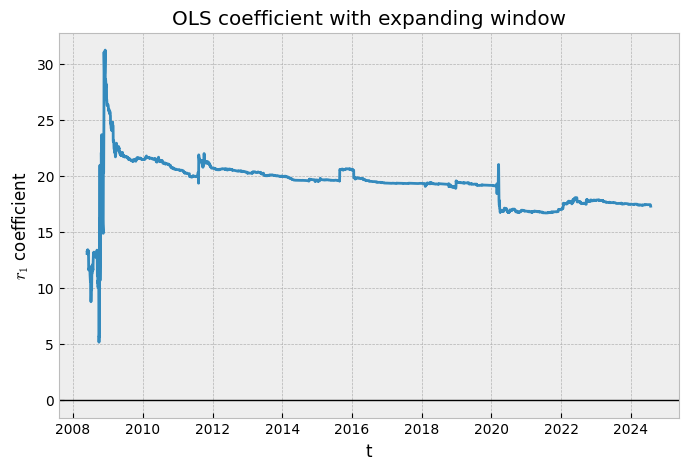

In [13]:
fig, ax = plt.subplots(figsize=(8, 5))
beta['r12'].mul(100).plot(ax=ax)
ax.set_ylabel('$r_1$ coefficient')
ax.set_title('OLS coefficient with expanding window')
ax.axhline(0, color='black', lw=1);

## $r_1$ and $r_{12}$

Finally a multivariate regression is applied. As can be seen from the summary below, both variables are statistically significant which means they carry different predictive power.

In [14]:
model = PredictiveAnalysisTS(pd.concat((r1, r12), axis=1), r13)

In [15]:
model.ols().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    r13   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     68.19
Date:                Mon, 29 Jul 2024   Prob (F-statistic):           6.92e-30
Time:                        09:03:56   Log-Likelihood:                 18109.
No. Observations:                4340   AIC:                        -3.621e+04
Df Residuals:                    4337   BIC:                        -3.619e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.471e-05   5.67e-05     -0.966      0.334      -0.000    5.64e-05
r1             0.0563      0.007      7.604      0.000       0.042       0.071
r12            0.1671      0.020      8.556      0.000       0.129       0.205
==============================================================================
Omnibus:                     1262.859   Durbin-Watson:                   2.236
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           125285.247
Skew:                           0.323   Prob(JB):                         0.00
Kurtosis:                      29.314   Cond. No.                         345.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
beta, r = model.ols_expanding(min_periods=13 * 21)

Dynamic OLS:   0%|          | 0/4340 [00:00<?, ?it/s]

Dynamic OLS:   8%|▊         | 345/4340 [00:00<00:01, 3427.76it/s]

Dynamic OLS:  16%|█▌        | 688/4340 [00:00<00:03, 1100.16it/s]

Dynamic OLS:  20%|██        | 873/4340 [00:00<00:03, 1028.35it/s]

Dynamic OLS:  23%|██▎       | 1015/4340 [00:00<00:03, 989.11it/s]

Dynamic OLS:  26%|██▌       | 1136/4340 [00:01<00:03, 963.01it/s]

Dynamic OLS:  29%|██▊       | 1246/4340 [00:01<00:03, 941.79it/s]

Dynamic OLS:  31%|███       | 1348/4340 [00:01<00:03, 925.51it/s]

Dynamic OLS:  33%|███▎      | 1446/4340 [00:01<00:03, 911.87it/s]

Dynamic OLS:  36%|███▌      | 1541/4340 [00:01<00:03, 898.24it/s]

Dynamic OLS:  38%|███▊      | 1633/4340 [00:01<00:03, 881.90it/s]

Dynamic OLS:  40%|███▉      | 1723/4340 [00:01<00:02, 872.58it/s]

Dynamic OLS:  42%|████▏     | 1811/4340 [00:01<00:02, 866.49it/s]

Dynamic OLS:  44%|████▎     | 1898/4340 [00:01<00:02, 860.49it/s]

Dynamic OLS:  46%|████▌     | 1985/4340 [00:02<00:02, 856.35it/s]

Dynamic OLS:  48%|████▊     | 2071/4340 [00:02<00:02, 851.67it/s]

Dynamic OLS:  50%|████▉     | 2157/4340 [00:02<00:02, 839.64it/s]

Dynamic OLS:  52%|█████▏    | 2242/4340 [00:02<00:02, 835.96it/s]

Dynamic OLS:  54%|█████▎    | 2326/4340 [00:02<00:02, 832.36it/s]

Dynamic OLS:  56%|█████▌    | 2410/4340 [00:02<00:02, 824.51it/s]

Dynamic OLS:  57%|█████▋    | 2493/4340 [00:02<00:02, 821.79it/s]

Dynamic OLS:  59%|█████▉    | 2576/4340 [00:02<00:02, 816.27it/s]

Dynamic OLS:  61%|██████    | 2658/4340 [00:02<00:02, 794.40it/s]

Dynamic OLS:  63%|██████▎   | 2738/4340 [00:02<00:02, 783.92it/s]

Dynamic OLS:  65%|██████▍   | 2817/4340 [00:03<00:01, 784.92it/s]

Dynamic OLS:  67%|██████▋   | 2896/4340 [00:03<00:01, 783.12it/s]

Dynamic OLS:  69%|██████▊   | 2975/4340 [00:03<00:01, 780.81it/s]

Dynamic OLS:  70%|███████   | 3054/4340 [00:03<00:01, 779.47it/s]

Dynamic OLS:  72%|███████▏  | 3132/4340 [00:03<00:01, 776.93it/s]

Dynamic OLS:  74%|███████▍  | 3210/4340 [00:03<00:01, 775.16it/s]

Dynamic OLS:  76%|███████▌  | 3288/4340 [00:03<00:01, 769.57it/s]

Dynamic OLS:  78%|███████▊  | 3365/4340 [00:03<00:01, 767.48it/s]

Dynamic OLS:  79%|███████▉  | 3442/4340 [00:03<00:01, 764.69it/s]

Dynamic OLS:  81%|████████  | 3519/4340 [00:04<00:01, 761.84it/s]

Dynamic OLS:  83%|████████▎ | 3596/4340 [00:04<00:01, 720.57it/s]

Dynamic OLS:  85%|████████▍ | 3672/4340 [00:04<00:00, 729.70it/s]

Dynamic OLS:  86%|████████▋ | 3747/4340 [00:04<00:00, 734.46it/s]

Dynamic OLS:  88%|████████▊ | 3823/4340 [00:04<00:00, 739.61it/s]

Dynamic OLS:  90%|████████▉ | 3898/4340 [00:04<00:00, 741.75it/s]

Dynamic OLS:  92%|█████████▏| 3973/4340 [00:04<00:00, 740.02it/s]

Dynamic OLS:  93%|█████████▎| 4048/4340 [00:04<00:00, 740.91it/s]

Dynamic OLS:  95%|█████████▌| 4123/4340 [00:04<00:00, 741.51it/s]

Dynamic OLS:  97%|█████████▋| 4198/4340 [00:04<00:00, 740.66it/s]

Dynamic OLS:  98%|█████████▊| 4273/4340 [00:05<00:00, 739.30it/s]

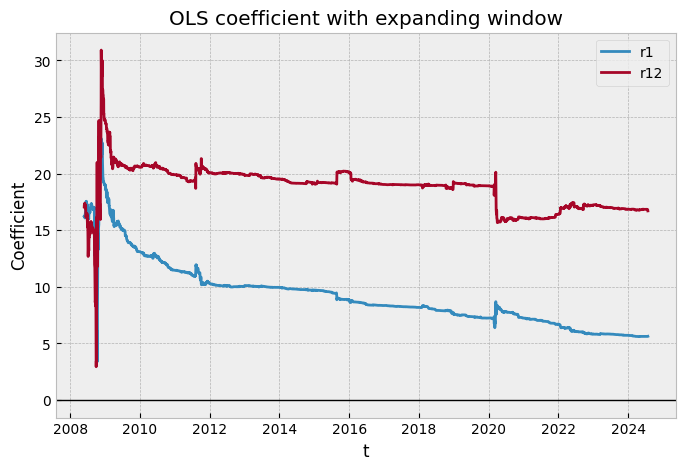

In [17]:
fig, ax = plt.subplots(figsize=(8, 5))
beta.drop('const', axis=1).mul(100).plot(ax=ax)
ax.set_ylabel('Coefficient')
ax.set_title('OLS coefficient with expanding window')
ax.axhline(0, color='black', lw=1);

Arguably, using the expanding window may not be very appropriate because the OLS always covers the GFC period and its estimates are sensitive to outliers. 

In light of this, the following chart shows the rolling OLS with a 3-month window. It shows that the coefficient for $r_1$ was high during the GFC and the sell-off in Mar-2020. Otherwise it tended to go down towards zero. On the other hand, the coefficient for $r_{12}$ remained high until Mar-2020 after which it turned negative.

In [18]:
beta, r = model.ols_rolling(window=13 * 21 * 3)

Dynamic OLS:   0%|          | 0/4340 [00:00<?, ?it/s]

Dynamic OLS:  16%|█▌        | 700/4340 [00:00<00:00, 6997.04it/s]

Dynamic OLS:  32%|███▏      | 1400/4340 [00:00<00:02, 1454.94it/s]

Dynamic OLS:  40%|████      | 1744/4340 [00:01<00:02, 1167.64it/s]

Dynamic OLS:  45%|████▌     | 1967/4340 [00:01<00:02, 1065.62it/s]

Dynamic OLS:  49%|████▉     | 2134/4340 [00:01<00:02, 1006.21it/s]

Dynamic OLS:  52%|█████▏    | 2270/4340 [00:01<00:02, 967.16it/s] 

Dynamic OLS:  55%|█████▌    | 2388/4340 [00:02<00:02, 941.82it/s]

Dynamic OLS:  57%|█████▋    | 2495/4340 [00:02<00:02, 921.24it/s]

Dynamic OLS:  60%|█████▉    | 2595/4340 [00:02<00:01, 901.42it/s]

Dynamic OLS:  62%|██████▏   | 2690/4340 [00:02<00:01, 884.73it/s]

Dynamic OLS:  64%|██████▍   | 2781/4340 [00:02<00:01, 872.91it/s]

Dynamic OLS:  66%|██████▌   | 2870/4340 [00:02<00:01, 863.25it/s]

Dynamic OLS:  68%|██████▊   | 2957/4340 [00:02<00:01, 852.38it/s]

Dynamic OLS:  70%|███████   | 3043/4340 [00:02<00:01, 840.23it/s]

Dynamic OLS:  72%|███████▏  | 3128/4340 [00:02<00:01, 825.07it/s]

Dynamic OLS:  74%|███████▍  | 3211/4340 [00:03<00:01, 816.72it/s]

Dynamic OLS:  76%|███████▌  | 3294/4340 [00:03<00:01, 818.47it/s]

Dynamic OLS:  78%|███████▊  | 3376/4340 [00:03<00:01, 807.33it/s]

Dynamic OLS:  80%|███████▉  | 3457/4340 [00:03<00:01, 805.36it/s]

Dynamic OLS:  82%|████████▏ | 3538/4340 [00:03<00:00, 802.71it/s]

Dynamic OLS:  83%|████████▎ | 3619/4340 [00:03<00:00, 799.89it/s]

Dynamic OLS:  85%|████████▌ | 3699/4340 [00:03<00:00, 776.19it/s]

Dynamic OLS:  87%|████████▋ | 3777/4340 [00:03<00:00, 739.46it/s]

Dynamic OLS:  89%|████████▉ | 3863/4340 [00:03<00:00, 771.05it/s]

Dynamic OLS:  91%|█████████ | 3949/4340 [00:04<00:00, 795.23it/s]

Dynamic OLS:  93%|█████████▎| 4036/4340 [00:04<00:00, 814.12it/s]

Dynamic OLS:  95%|█████████▍| 4122/4340 [00:04<00:00, 826.69it/s]

Dynamic OLS:  97%|█████████▋| 4208/4340 [00:04<00:00, 836.10it/s]

Dynamic OLS:  99%|█████████▉| 4294/4340 [00:04<00:00, 842.48it/s]

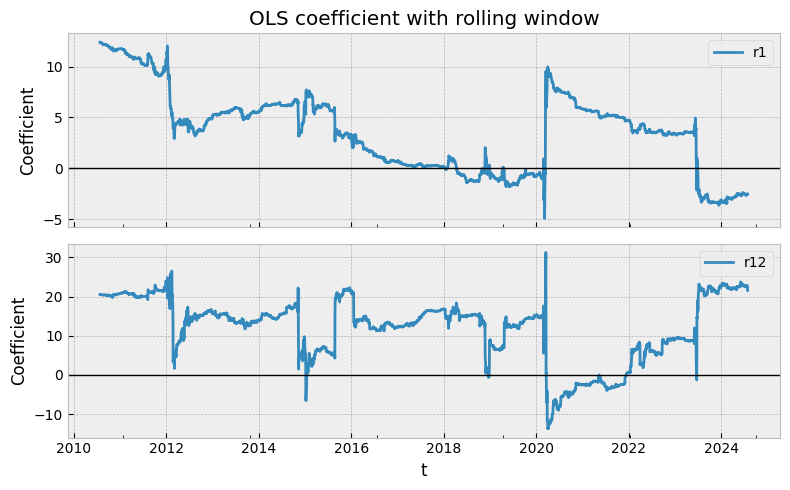

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(8, 5), sharex=True)
beta['r1'].mul(100).plot(ax=axes[0])
beta['r12'].mul(100).plot(ax=axes[1])
axes[0].set_title('OLS coefficient with rolling window')

for ax in axes:
    ax.set_ylabel('Coefficient')
    ax.axhline(0, color='black', lw=1)
    ax.legend()
fig.tight_layout();

# Backtest

In this section, we run some backtests to see the performance of market timing strategies suggested in the paper.

## $r_1$ only

In [20]:
engine_r1 = BacktestEngine(
    strategy=Strategy.DELTA_ONE.value,
    instrument=instrument,
    signal=signal.IntradayMomentumGao2018(r1=True, r12=False),
    log_level=logging.WARN,
)
engine_r1.run()

In [21]:
spy_r1_only = engine_r1.calculate_equity_curve(calculate_net=False)
spy_r1_only = spy_r1_only.resample('b').last().fillna(method='pad')

As a comparison, the "always long" strategy is computed which always takes a position during the last 30 minutes regardless of intraday moves.

In [22]:
engine_always_long = BacktestEngine(
    strategy=Strategy.DELTA_ONE.value,
    instrument=instrument,
    signal=signal.AlwaysLongGao2018(),
    log_level=logging.WARN,
)
engine_always_long.run()

In [23]:
spy_always_long = engine_always_long.calculate_equity_curve(calculate_net=False)
spy_always_long = spy_always_long.resample('b').last().fillna(method='pad')

The chart below shows the performance of the $r_1$ strategy as well as the always long one. In line with the OLS result, the $r_1$ strategy performed particularly well during the GFC and COVID sell-off. Also the chart illustrates the benefit of using the signal because the "always long" strategy actually generated negative returns during the sample period. 

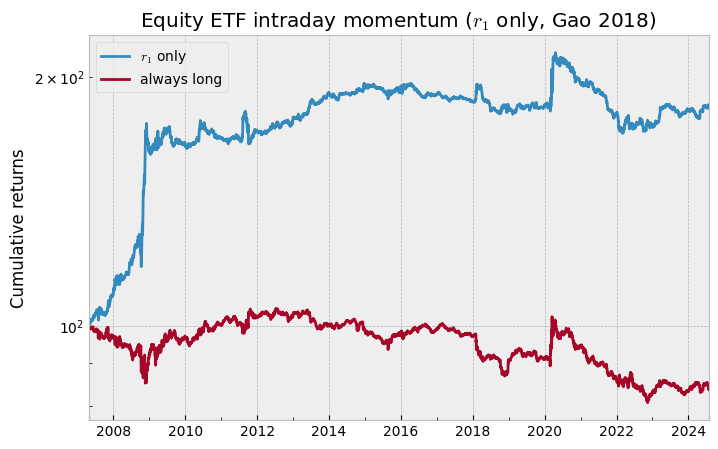

In [24]:
fig, ax = plt.subplots(figsize=(8, 5))
levels = pd.concat((spy_r1_only.rename('$r_1$ only'),
                    spy_always_long.rename('always long')), axis=1)
levels.plot(ax=ax, logy=True);
ax.set_title('Equity ETF intraday momentum ($r_1$ only, Gao 2018)')
ax.set_ylabel('Cumulative returns');

In [25]:
levels.pipe(Performance).summary()

,$r_1$ only,always long
CAGR,0.034508,-0.009929
Annualised vol,0.058974,0.059031
Sharpe ratio,0.585139,-0.168193
Max drawdown,0.201881,0.231278
Calmar ratio,0.170931,-0.042929
Skewness,1.380839,0.372045
Kurtosis,27.624678,27.740378
Worst return,-0.039508,-0.041329
Worst 1d return,-0.039508,-0.041329
Worst 1w return,-0.049068,-0.057129


## $r_{12}$ only

In [26]:
engine_r12 = BacktestEngine(
    strategy=Strategy.DELTA_ONE.value,
    instrument=instrument,
    signal=signal.IntradayMomentumGao2018(r1=False, r12=True),
    log_level=logging.WARN,
)
engine_r12.run()

In [27]:
spy_r12_only = engine_r12.calculate_equity_curve(calculate_net=False)
spy_r12_only = spy_r12_only.resample('b').last().fillna(method='pad')

The overall characteristics for $r_{12}$ is similar to that of $r_1$ albeit a weaker Sharpe ratio, which is consistent with the paper.

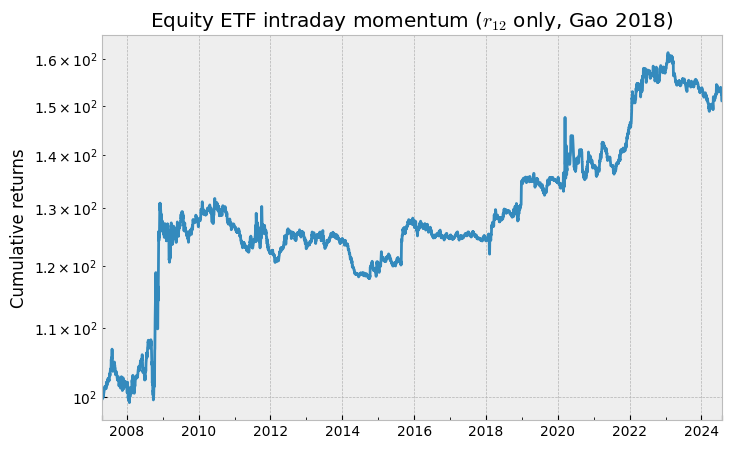

In [28]:
fig, ax = plt.subplots(figsize=(8, 5))
spy_r12_only.plot(ax=ax, logy=True);
ax.set_title('Equity ETF intraday momentum ($r_{12}$ only, Gao 2018)')
ax.set_ylabel('Cumulative returns');

In [29]:
spy_r12_only.pipe(Performance).summary()

,equity_curve
CAGR,0.023122
Annualised vol,0.058845
Sharpe ratio,0.392929
Max drawdown,0.105538
Calmar ratio,0.219086
Skewness,0.814451
Kurtosis,27.969938
Worst return,-0.041329
Worst 1d return,-0.041329
Worst 1w return,-0.049168


## $r_1$ and $r_{12}$

Lastly, this is a strategy which uses both $r_1$ and $r_{12}$. Positions are taken only if both signals agree.

In [30]:
engine_both = BacktestEngine(
    strategy=Strategy.DELTA_ONE.value,
    instrument=instrument,
    signal=signal.IntradayMomentumGao2018(r1=True, r12=True),
    log_level=logging.WARN,
)
engine_both.run()

In [31]:
spy_both = engine_both.calculate_equity_curve(calculate_net=False)
spy_both = spy_both.resample('b').last().fillna(method='pad')

Interestingly unlike Gao 2018, the combined strategy (margianlly) outperformed the $r_1$ only strategy in terms of Sharpe ratio during the sample period analysed in this notebook.

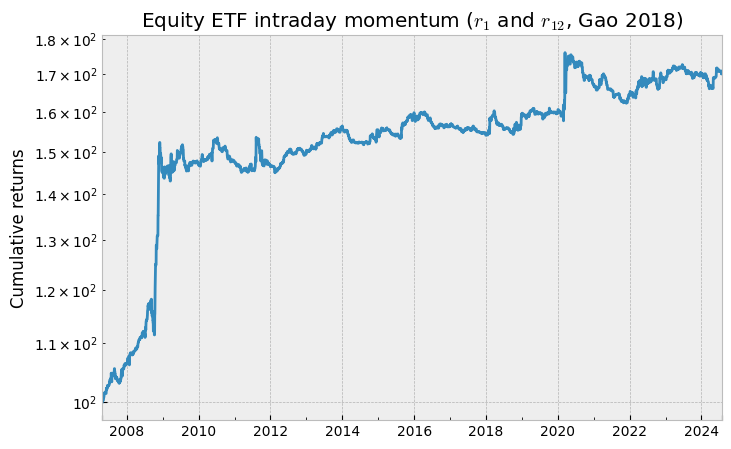

In [32]:
fig, ax = plt.subplots(figsize=(8, 5))
spy_both.plot(ax=ax, logy=True);
ax.set_title('Equity ETF intraday momentum ($r_1$ and $r_{12}$, Gao 2018)')
ax.set_ylabel('Cumulative returns');

In [33]:
pd.concat((spy_r1_only.rename('r1_only'), 
           spy_both.rename('r1_and_r12')), axis=1).pipe(Performance).summary()

,r1_only,r1_and_r12
CAGR,0.034508,0.029749
Annualised vol,0.058974,0.044460
Sharpe ratio,0.585139,0.669105
Max drawdown,0.201881,0.078623
Calmar ratio,0.170931,0.378373
Skewness,1.380839,2.668447
Kurtosis,27.624678,61.237832
Worst return,-0.039508,-0.039508
Worst 1d return,-0.039508,-0.039508
Worst 1w return,-0.049068,-0.029525


This appears to be related to the sample period. In fact, performance until 2013 which the original paper uses shows that $r_1$ performed better, however again the difference is marginal.

In [34]:
pd.concat((spy_r1_only.rename('r1_only'), 
           spy_both.rename('r1_and_r12')), axis=1)[:'2013'].pipe(Performance).summary()

,r1_only,r1_and_r12
CAGR,0.094056,0.064532
Annualised vol,0.072902,0.053523
Sharpe ratio,1.290160,1.205690
Max drawdown,0.087050,0.060483
Calmar ratio,1.080484,1.066939
Skewness,1.306874,2.831470
Kurtosis,16.946325,34.333508
Worst return,-0.030637,-0.030637
Worst 1d return,-0.030637,-0.030637
Worst 1w return,-0.049068,-0.029525


## Other ETFs

The author also investigates if this pattern can be observed outside SPY. The following ETFs are used:
- QQQ: Invesco QQQ Trust (NASDAQ-100)
- XLF: Financial Select Sector SPDR ETF
- IWM: iShares Russell 2000 ETF
- DIA: SPDR Dow Jones Industrial Average ETF
- EEM: iShares MSCI Emerging Markets ETF
- FXI: iShares China Large-Cap ETF
- EFA: iShares MSCI EAFE ETF (MSCI EAFE Index composed of large- and mid-capitalization developed market equities, excluding the U.S. and Canada)
- VWO: Vanguard FTSE Emerging Markets ETF
- IYR: iShares US Real Estate ETF
- TLT: iShares 20+ Year Treasury Bond ETF

In [35]:
etfs = ['QQQ', 'XLF', 'IWM', 'DIA', 'EEM', 'FXI', 'EFA', 'VWO', 'IYR', 'TLT']
common_params = dict(
    strategy=Strategy.DELTA_ONE.value,
    log_level=logging.WARN,
)

flgs = dict(
    r1_only=dict(r1=True, r12=False),
    r12_only=dict(r1=False, r12=True),
    both=dict(r1=True, r12=True),
)

In [36]:
other_etf_result = []

for etf in etfs:
    instrument = InstrumentDef(etf, freq='30min', timezone='America/New_York',
                               start_time='9:30', end_time='16:00', pnl_type=PnLType.CLOSE.value)
    
    i_result = []
    for k, v in flgs.items():
        engine = BacktestEngine(
            instrument=instrument,
            signal=signal.IntradayMomentumGao2018(**v),
            **common_params,
        )
        engine.run()
        levels = engine.calculate_equity_curve(calculate_net=False)
        levels = levels.resample('b').last().fillna(method='pad')
        i_result.append(levels)
        
    i_result = pd.concat(i_result, axis=1, keys=flgs.keys())
    other_etf_result.append(i_result)
    
other_etf_result = pd.concat(other_etf_result, axis=1, keys=etfs)

As can be seen visually below, for most of the ETFs, the majority of performance is coming from the financial crisis and to a lesser extent from March 2020. For EM and China ETFs, the performance has been flattish since the crisis which suggests that the intraday momentum is a US or DM phenomenon. 

Furthermore, the performance for TLT is a lot weaker than the equity ETFs. This result is consistent with Baltussen et al 2020 who found that intraday momentum is particularly stronger in equities and commodities, and weaker in fixed income and FX.

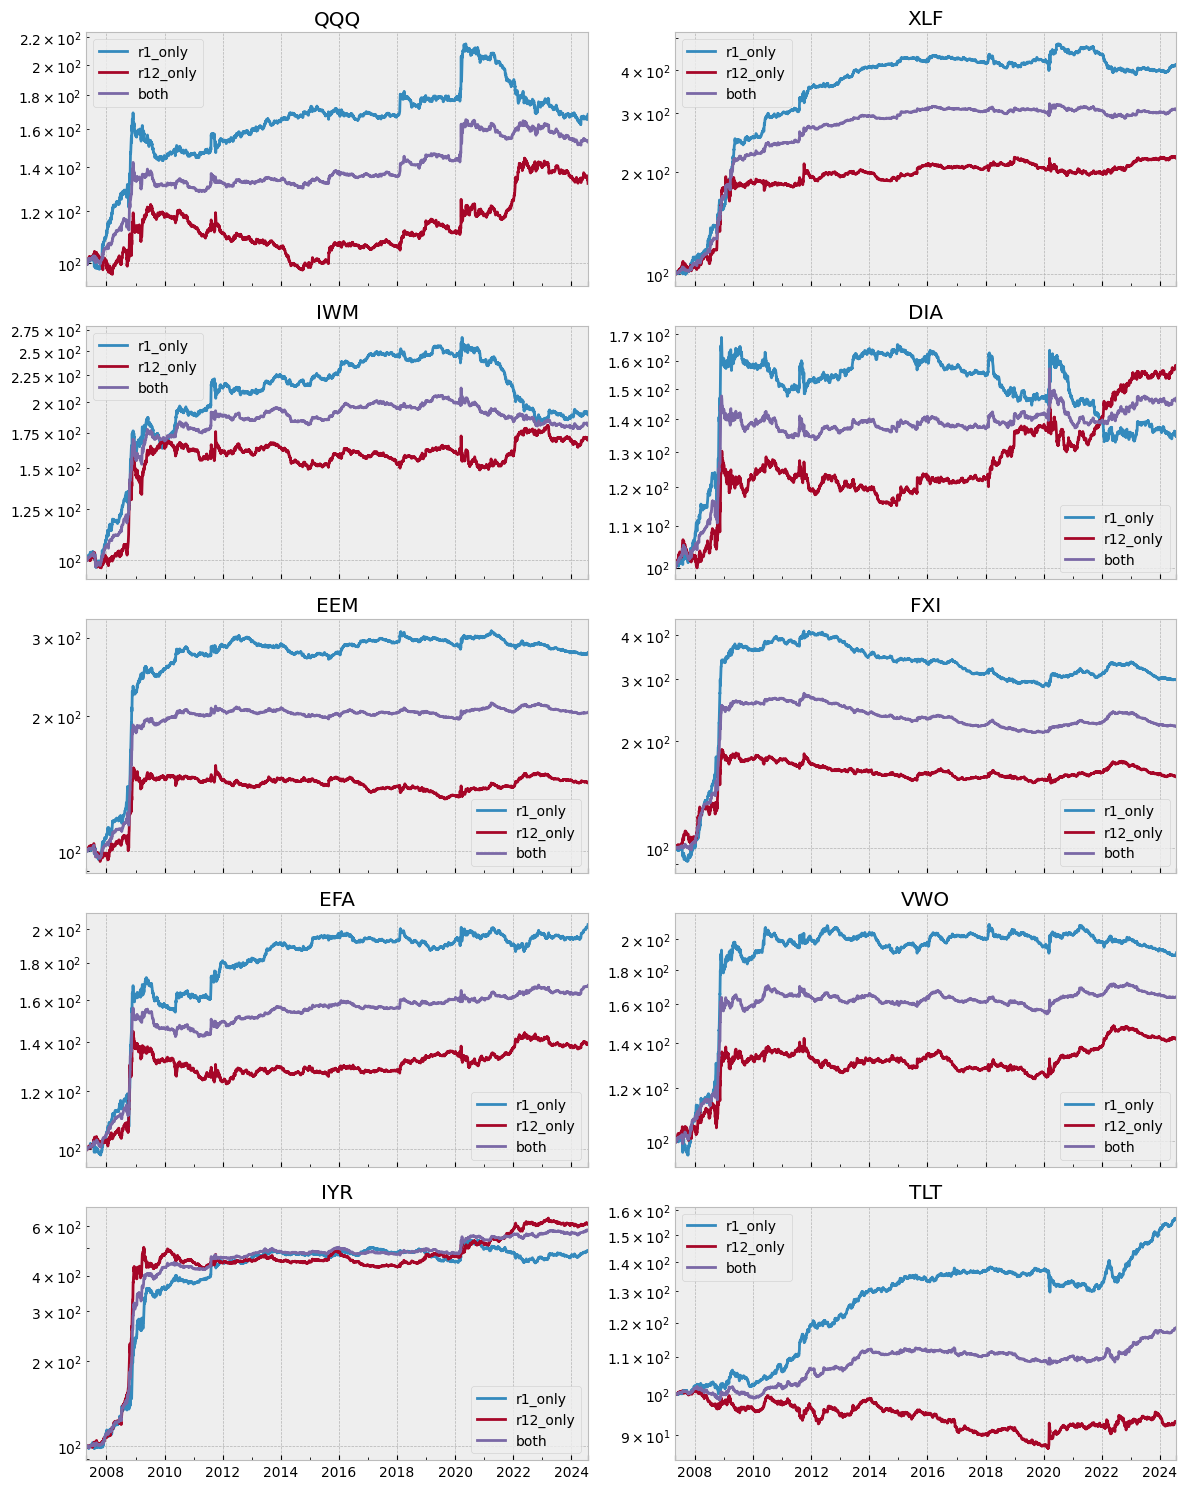

In [37]:
fig, axes = plt.subplots(5, 2, figsize=(12, 15), sharex=True)
axes = axes.flatten()

for etf, ax in zip(etfs, axes):
    other_etf_result[etf].plot(ax=ax, logy=True)
    ax.set_title(etf)
    
fig.tight_layout();

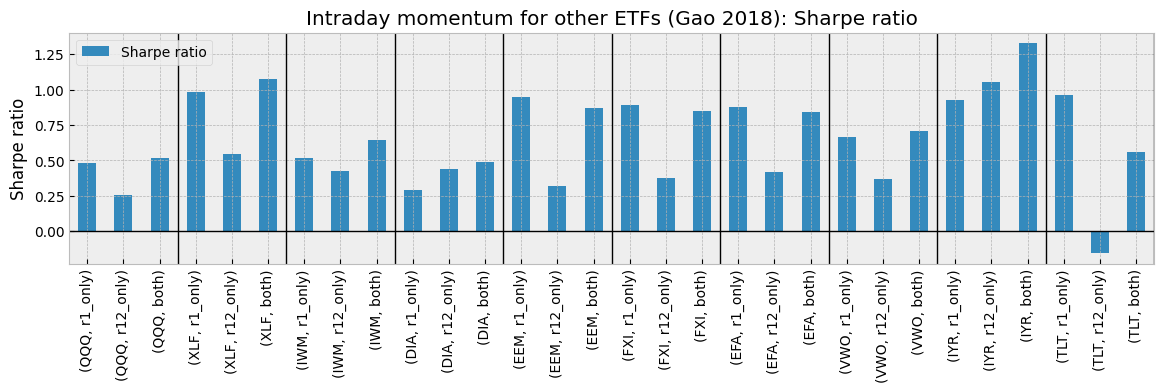

In [38]:
fig, ax = plt.subplots(figsize=(14, 3))
other_etf_result.dropna().pipe(Performance).sharpe().T.plot(kind='bar', ax=ax)
ax.set_ylabel('Sharpe ratio')
ax.axhline(0, color='black', lw=1)
for i in range(len(etfs)):
    ax.axvline((i + 1) * 3 - 0.5, color='black', lw=1)
ax.legend(loc='upper left');
ax.set_title('Intraday momentum for other ETFs (Gao 2018): Sharpe ratio');

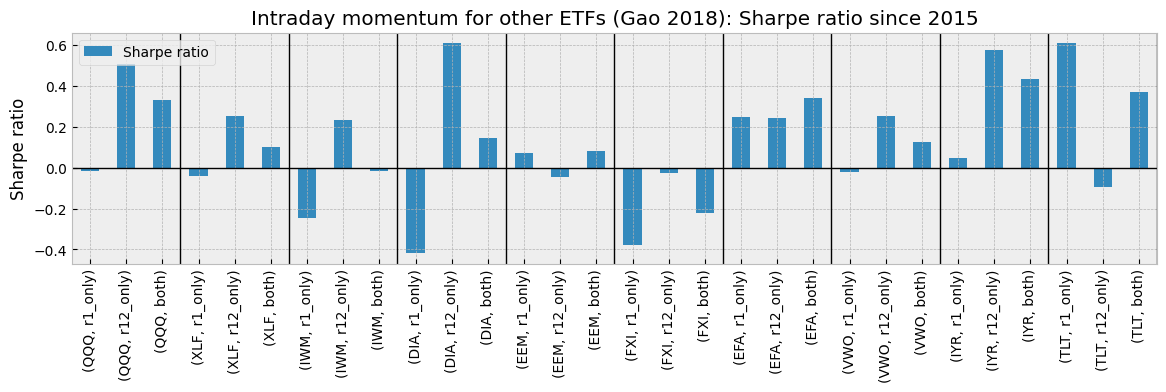

In [39]:
fig, ax = plt.subplots(figsize=(14, 3))
other_etf_result['2015':].dropna().pipe(Performance).sharpe().T.plot(kind='bar', ax=ax)
ax.set_ylabel('Sharpe ratio')
ax.axhline(0, color='black', lw=1)
for i in range(len(etfs)):
    ax.axvline((i + 1) * 3 - 0.5, color='black', lw=1)
ax.legend(loc='upper left');
ax.set_title('Intraday momentum for other ETFs (Gao 2018): Sharpe ratio since 2015');

## Post publication

In [40]:
publication_date = pytz.timezone('America/New_York').localize(datetime(2018, 5, 31))

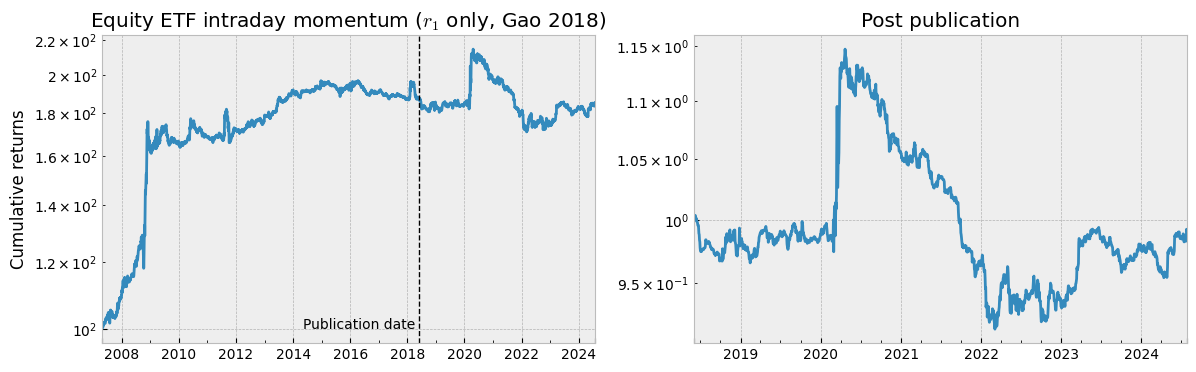

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
spy_r1_only.plot(ax=ax[0], logy=True);
ax[0].set_title('Equity ETF intraday momentum ($r_1$ only, Gao 2018)')
ax[0].set_ylabel('Cumulative returns');
ax[0].axvline(publication_date, lw=1, ls='--', color='black')
ax[0].text(publication_date, 100, 'Publication date ', ha='right')

spy_r1_only.loc[publication_date:].pipe(rebase).plot(ax=ax[1], logy=True);
ax[1].set_title('Post publication');

# Reference
- Baltussen, G., Da, Z., Lammers, S. and Martens, M., 2020. Hedging demand and market intraday momentum. Journal of Financial Economics.
- Gao, L., Han, Y., Li, S.Z. and Zhou, G., 2018. Market intraday momentum. Journal of Financial Economics, 129(2), pp.394-414.

In [42]:
print(f'Updated: {datetime.now(pytz.utc):%d-%b-%Y %H:%M}')

Updated: 29-Jul-2024 09:05
